In [1]:
from bokeh.io import output_notebook
from bokeh.models import Label
from bokeh.plotting import figure, output_file, show
from collections import Counter
from functools import reduce
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from IPython.core.interactiveshell import InteractiveShell
from nltk.corpus import stopwords
from plotly.offline import iplot
from pprint import pprint
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from textblob import TextBlob
import collections
import csv
import cufflinks
import emoji
import en_core_web_sm
import gensim
import gensim.corpora as corpora
import itertools
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
import pyLDAvis
import re
import scattertext as st
import seaborn as sns
import spacy
import spacy
import warnings 

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [2]:
get_ipython().run_line_magic('matplotlib', 'inline')
InteractiveShell.ast_node_interactivity = 'all'
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

output_notebook()
pd.options.display.max_columns = 30
warnings.filterwarnings('ignore')

cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

nlp = spacy.load('en_core_web_sm')

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\bokeh\io\notebook.py:487: DeprecationWarning:

The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.



Loading BokehJS ...

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\bokeh\io\notebook.py:487: DeprecationWarning:

The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.



In [3]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [4]:
words = set(nltk.corpus.words.words())

In [5]:
filename: str = "./../assets/ifa-ie-articles.csv"
df = pd.read_csv(filename)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 869 entries, 0 to 868
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   URL           869 non-null    object
 1   Heading       869 non-null    object
 2   Date          869 non-null    object
 3   Trend         869 non-null    object
 4   Text          869 non-null    object
 5   HTML Content  869 non-null    object
dtypes: object(6)
memory usage: 40.9+ KB


In [7]:
def vader_scorer(df):
    '''Compute vaderSentiment scores for each tweet
    Args: Dataframe containing a 'text' column
    Returns: Dataframe of vader scores
    '''
    analyzer = SentimentIntensityAnalyzer()
    vader_scores = df.loc[:,'text'].map(analyzer.polarity_scores)

    dvec = DictVectorizer()
    vader_scores = dvec.fit_transform(vader_scores)
    
    vader_scores = pd.DataFrame(vader_scores.toarray(),columns=dvec.feature_names_)
    return vader_scores

In [8]:
vader_scores = vader_scorer(df)
df = pd.concat([df,vader_scores], axis=1)

KeyError: 'text'

In [11]:
beef_dataframe = df[df['Trend'] == 'beef']
dairy_dataframe = df[df['Trend'] == 'dairy']
#TODO: Michael
dairy_dataframe.head()

,URL,Heading,Date,Trend,Text,HTML Content
628,https://www.ifa.ie/farm-sectors/ifa-calf-webin...,"IFA Calf Webinar Moved to Wed, Jan 26th",24 January 2022,dairy,\r\nIFA’s Dairy Calf webinar has been moved fr...,"<div class=""single-content"">\r\n<p>IFA’s Dairy..."
629,https://www.ifa.ie/campaigns/key-amendments-on...,"Key Amendments on Animal Transport Carried, Bu...",20 January 2022,dairy,\r\nIFA President Tim Cullinan said the voting...,"<div class=""single-content"">\r\n<p>IFA Preside..."
630,https://www.ifa.ie/farm-sectors/ifa-to-hold-da...,IFA to Hold Dairy Calf Webinar as Calving Seas...,20 January 2022,dairy,\r\n\r\n\r\nPlease note the change in date for...,"<div class=""single-content"">\r\n<div class=""wp..."
631,https://www.ifa.ie/policy-areas/food-exports-s...,Food Exports Show the Importance of the Sector...,12 January 2022,dairy,\r\nIFA President Tim Cullinan said the figure...,"<div class=""single-content"">\r\n<p>IFA Preside..."
632,https://www.ifa.ie/farm-sectors/milk-price-mus...,Milk Price Must Increase for December Supplies,7 January 2022,dairy,\r\nThe Ornua PPI for December has climbed to ...,"<div class=""single-content"">\r\n<p>The Ornua P..."


Hypothesis 1:
Null Hypothesis is that sentiment for the beef and the dairy was the same

NameError: name 'tweets' is not defined

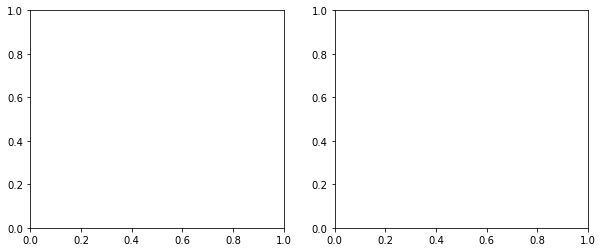

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
sns.violinplot(y='compound', x='trend', data=df[tweets.topical_orgs != ''], ax=ax[0])
sns.boxplot(y='compound', x='trend', data=df[tweets.topical_orgs != ''], ax=ax[1])
plt.tight_layout()
show.plt

In [11]:
print('StDev of beef sentiment',np.std(df[df.trend == 'beef']['compound']))
print('StDev of NHS sentiment',np.std(df[df.trend == 'dairy']['compound']))

AttributeError: 'DataFrame' object has no attribute 'trend'

Running SciPy's t-test:

Note: had sample standard deviations not been equal, then set equal_var = False to use Welch's t-statistic (ie. out standard error is calculated differently because we can't pool our two distributions together)

In [12]:
stats.ttest_ind(df[df.trend == 'beef']['compound'],
                df[df.trend == 'dairy']['compound'], equal_var=True)

NameError: name 'stats' is not defined

Alternatively could have run Statsmodel API's ztest:

In [13]:
sm.stats.ztest(df[df.trend == 'beef']['compound'],
               df[df.trend == 'dairy']['compound'])

NameError: name 'sm' is not defined

So p-value is essentially 0, which says that if null hypothesis is assumed to be true, then there is 0 (or very small) chance of observing what we've just observed as the alternate hypothesis.
How small the p-value is, assuming proper statistical process, is how much confidence we have in rejecting the null hypothesis. Because we're saying there's no chance we'd have seen this alternate hypothesis (so far into the tail as it was) if the null was true.
We can construct a 95% confidence interval for our difference in sample means to further confirm this:

In [14]:
p_bf = np.mean(df[df.trend == 'beef']['compound'])
p_dr = np.mean(df[df.trend == 'dairy']['compound'])

num_bf = len(df[df.trend == 'beef'])
num_dr = len(df[df.trend == 'dairy'])

AttributeError: 'DataFrame' object has no attribute 'trend'

The s.e. for each population (as we're comparing MEANS here) is simply: sigma / sqrt(n)

In [ ]:
se_bf = np.std(df[df.trend == 'beef']['compound']) / np.sqrt(num_bf)
se_dr = np.std(df[df.trend == 'dairy']['compound']) / np.sqrt(num_dr)

Alternatively, statsmodels has a function s.e. of the mean of a distribution:

In [ ]:
print('beef sentiment s.e.', stats.sem(df[df.trend == 'beef']['compound'], axis=None))
print('dairy sentiment s.e.', stats.sem(df[df.trend == 'dairy']['compound'], axis=None))

With the standard error for both populations to be used in CI formula below: SE(1,2) = SQR(SE1^2 + SE2^2)

In [ ]:
se_diff = np.sqrt(se_br**2 + se_dr**2)

In [ ]:
diff = p_bf - p_dr
lcb = diff - (1.96 * se_diff)
ucb = diff + (1.96 * se_diff)
(lcb, ucb)

Visualise sentiment
Can we visualise what type of sentiment ifi had for the beef vs the dairy? Let's look at the words that were being used to better understand how the ifi described each entity:

In [10]:
beef_text = " ".join(art for art in df.text[df.trend=='beef'])
dairy_text = " ".join(art for art in df.text[df.trend=='dairy'])

stopwords = set(STOPWORDS)
stopwords.update(['http', 'https', 'www', 'amp', 'ly', 'bit'])

gov_wordcloud = WordCloud(stopwords=stopwords).generate(gov_text)
nhs_wordcloud = WordCloud(stopwords=stopwords).generate(nhs_text)

fig, ax = plt.subplots(nrows=2, figsize=(10,10))
ax[0].imshow(gov_wordcloud)
ax[0].set_title('beef')
ax[0].axis('off')
ax[1].imshow(nhs_wordcloud)
ax[1].set_title('dairy')
ax[1].axis('off')
plt.tight_layout()
plt.show

AttributeError: 'DataFrame' object has no attribute 'trend'